In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
%matplotlib inline

In [3]:
import optax
import numpy as onp
import jax.numpy as jnp
import jax.random
import jax_md
from jax import jit, vmap, grad, lax
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
import data
data_raw = data.get_gpaw_trajectories("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [6]:
from collections import defaultdict
#SPECISES_MAP = defaultdict(lambda: 2)
#SPECISES_MAP[16] = 0
#SPECISES_MAP[42] = 1

opt = optax.chain(optax.clip_by_global_norm(jnp.float32(1.0)), optax.adam(jnp.float32(3e-4)))

In [7]:
def prepare_tensors(atoms):
  lattice = atoms.cell.array.astype(onp.float32)
  displacement, shift = jax_md.space.periodic_general(lattice.T, fractional_coordinates=False)
  species = jnp.array(atoms.get_atomic_numbers(), dtype=jnp.int32)
  neighbor_fn, init_fn_bp, energy_fn_bp = jax_md.energy.graph_network_neighbor_list(
    displacement_fn=displacement,
    nodes=jnp.expand_dims(species, -1).astype(jnp.float32),
    box_size=21,
    r_cutoff=3.9,
    dr_threshold=0.2)
  neighbor = neighbor_fn(atoms.positions, extra_capacity=3)
  
  @jit
  def train_energy_fn(params, R):
    _neighbor = neighbor_fn(R, neighbor)
    return energy_fn_bp(params, R, _neighbor)

  # Vectorize over states, not parameters.
  vectorized_energy_fn = vmap(train_energy_fn, (None, 0))

  grad_fn = grad(train_energy_fn, argnums=1)
  force_fn = lambda params, R, **kwargs: -grad_fn(params, R)
  vectorized_force_fn = vmap(force_fn, (None, 0))
  
  @jit
  def energy_loss(params, R, energy_targets):
    return jnp.mean((vectorized_energy_fn(params, R) - energy_targets) ** 2)

  @jit
  def force_loss(params, R, force_targets):
    dforces = vectorized_force_fn(params, R) - force_targets
    return jnp.mean(jnp.sum(dforces ** 2, axis=(1, 2)))
  
  @jit
  def loss(params, R, targets):
    return energy_loss(params, R, targets[0]) + force_loss(params, R, targets[1])
  
  @jit
  def update_step(params, opt_state, R, labels):
    updates, opt_state = opt.update(grad(loss)(params, R, labels),
                                    opt_state)
    return optax.apply_updates(params, updates), opt_state

  
  @jit
  def update_epoch(params_and_opt_state, batches):
    def inner_update(params_and_opt_state, batch):
      params, opt_state = params_and_opt_state
      b_xs, b_labels = batch

      return update_step(params, opt_state, b_xs, b_labels), 0
    return lax.scan(inner_update, params_and_opt_state, batches)[0]

  return init_fn_bp, neighbor_fn, vectorized_energy_fn, energy_loss, update_epoch

In [8]:
data_processed = {}
for key, defect_vars in data_raw.items():
  energies = []
  coordinates = []
  forces = []
  for traj in defect_vars:
    energies.append(jnp.array([a.get_potential_energy() for a in traj], dtype=jnp.float32))
    coordinates.append(jnp.array([a.positions for a in traj], dtype=jnp.float32))
    forces.append(jnp.array([a.get_forces() for a in traj], dtype=jnp.float32))
  #data_processed[key] = energies, coordinates, forces
  data_processed[key] = (
    jnp.concatenate(energies), jnp.concatenate(coordinates), jnp.concatenate(forces))

In [9]:
tensors_per_id = {k: prepare_tensors(v[0][0]) for k, v in data_raw.items()}

In [10]:
key = jax.random.PRNGKey(42)
BASE='id18'
initial_coords = jnp.array(data_raw[BASE][0][0].positions)
base_funcs  = tensors_per_id[BASE]
neighbor = base_funcs[1](initial_coords, extra_capacity=3)
params = base_funcs[0](key, initial_coords, neighbor)

In [11]:
opt_state = opt.init(params)
train_energy_error = []

In [12]:
from IPython import display

In [13]:
BATCH_SIZE = 32
@jit
def make_batches(lookup, ERF):
  batch_Rs = []
  batch_Es = []
  batch_Fs = []

  for i in range(0, len(lookup), BATCH_SIZE):
    if i + BATCH_SIZE > len(lookup):
      break

    idx = lookup[i:i + BATCH_SIZE]

    batch_Rs += [ERF[1][idx]]
    batch_Es += [ERF[0][idx]]
    batch_Fs += [ERF[2][idx]]

  return jnp.stack(batch_Rs), (jnp.stack(batch_Es), jnp.stack(batch_Fs))

In [ ]:
for epoch in range(1000):
  for defect_id in data_processed.keys():
    lookup = onp.arange(len(data_processed[defect_id][0]))
    onp.random.shuffle(lookup)
    batches = make_batches(lookup, data_processed[defect_id])
    params, opt_state = tensors_per_id[defect_id][4](
      (params, opt_state), batches)
      # Total eV
    train_energy_error += [onp.sqrt(tensors_per_id[defect_id][3](
        params, data_processed[defect_id][1], data_processed[defect_id][0]))]
    print(defect_id, train_energy_error[-1])
  display.clear_output(wait=True)

id31 3.8113945
id42 29.013624
id1 6.4406486
id27 13.450766
id12 18.880045
id11 14.213508
id47 29.478323
id28 3.0087738
id26 12.9168415
id2 21.821451
id0 33.818287
id25 20.579311
id10 15.115067
id37 3.9801652
id32 2.1981077
id20 3.258299
id3 6.738811
id44 51.716606
id19 11.611928
id4 12.142942
id38 16.954065
id8 6.778307
id39 6.1841116
id6 12.465326


In [19]:
predicted_E = []
true_E = []
for defect_id in data_processed.keys():
  predicted_E.append(tensors_per_id[defect_id][2](params, data_processed[defect_id][1]))
  true_E.append(data_processed[defect_id][0])
predicted_E = onp.concatenate(predicted_E)
true_E = onp.concatenate(true_E)
  
min_energy = min(true_E.min(), predicted_E.min())
max_energy = max(true_E.max(), predicted_E.max())
plot_range = onp.linspace(min_energy, max_energy, 10)       

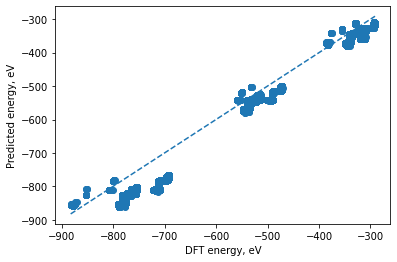

In [20]:
fig, ax = plt.subplots()
ax.scatter(true_E, predicted_E)
plt.plot(plot_range, plot_range, '--')      
ax.set_ylabel("Predicted energy, eV")
ax.set_xlabel("DFT energy, eV");